In [1]:
!nvidia-smi

Wed Feb 21 14:11:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   31C    P8              20W / 215W |   1787MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
os.chdir('..')
os.getcwd()

cuda


'/home/linh/projects/IConNet'

In [4]:
from torchaudio.datasets import IEMOCAP
data_dir = '../data/IEMOCAP/'
data = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='scripted'
              )
all_labels = sorted(list(set(datapoint[3] for datapoint in data)))
print(all_labels)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [5]:
labels = ['ang', 'hap', 'neu', 'sad']


def label_to_index(word):
    return torch.tensor(labels.index(word), dtype=torch.int64)
def index_to_label(index):
    return labels[index]
    
data_x = []
data_y = []
for d in data:
    if d[3] in labels:
        data_x.append(d)
        data_y.append(label_to_index(d[3]))

In [6]:
train_set, test_set = train_test_split(
    data_x, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(train_set))
print("Test: %i" % len(test_set))

Train: 1768
Test: 442


In [7]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=2):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, _, label, *_ in batch:
        length = len(waveform)
        max_length = sample_rate * max_duration_in_second
        offset = max(0, (length - max_length) // 2)
        tensors += [waveform[offset: length-offset]]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 4

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [8]:
from IConNet.nn.frontend import FeBlocks
from IConNet.nn.classifier import Classifier
from typing import Literal, Optional, Union
from einops import rearrange, reduce
import torch.nn as nn
from IConNet.nn.activation import NLReLU
from IConNet.utils import config as cfg

from mamba_ssm import Mamba

class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.15) -> None:
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout))
    
    def forward(self, x):
        return self.ffn(x)

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_conv=4, d_state=2, expand=2) -> None:
        super().__init__()
        self.sa_head = Mamba( # num_parameters = 3 * expand * d_model^2
            d_model=d_model, 
            d_state=d_state, 
            d_conv=d_conv, 
            expand=expand)
        self.ffn = FeedForward(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.sa_head(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class M17(nn.Module):
    """
    A classification model using FIRConv + LSTM with hidden state
    """

    def __init__(
            self, 
            config, 
            n_input=None, 
            n_output=None):
        
        super().__init__()
        self.config = config
        if n_input is None:
            n_input = config.n_input
        if n_output is None:
            n_output = config.n_output
        self.n_input = n_input 
        self.n_output = n_output
        self.fe_blocks = FeBlocks(
            n_input_channel = n_input, 
            n_block = config.fe.n_block,
            n_channel = config.fe.n_channel, 
            kernel_size = config.fe.kernel_size, 
            stride = config.fe.stride, 
            window_k = config.fe.window_k,
            residual_connection_type = config.fe.residual_connection_type,
            filter_type = config.fe.filter_type,
            conv_mode=config.fe.conv_mode,
            norm_type=config.fe.norm_type,
            pooling = None) # if pooling here, n_feature=1
        self.fe_n_feature = self.fe_blocks.n_output_channel
        self.pooling = cfg.get_optional_config_value(self.config.seq.pooling)

        self.seq_blocks = nn.Sequential(*[MambaBlock( # num_parameters = 3 * expand * d_model^2
        # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=self.fe_n_feature, # Model dimension d_model
            d_state=config.seq.d_state,  # SSM state expansion factor
            d_conv=config.seq.d_conv,    # Local convolution width
            expand=config.seq.expand,    # Block expansion factor
        ) for _ in range(config.seq.n_block)]) # input: B N C -> output: B N C
        self.n_feature = self.fe_n_feature
        self.cls_head = Classifier(
            n_input = self.n_feature,
            n_output = n_output,
            n_block = config.cls.n_block, 
            n_hidden_dim = config.cls.n_hidden_dim
        )

    def forward(self, x):
        x = rearrange(self.fe_blocks(x), 'b c n -> b n c')
        x = reduce(self.seq_blocks(x),
                     'b n c -> b c', self.pooling)
        x = self.cls_head(x)
        return x 


In [9]:
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/mamba.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M17(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 9
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  seq_type: mamba
  d_state: 2
  d_conv: 4
  expand: 2
  n_block: 1
  n_channel: 97
  pooling: mean
cls:
  n_block: 2
  n_hidden_dim:
  - 128
  - 128
  norm_type: LayerNorm

M17(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
           

In [10]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [11]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [12]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                            | 0.0036231884057971015/10 [00:00<27:58, 167.87s/it]

Train Epoch: 1 [0/1768 (0%)]	Loss: 1.204373
Mem before-during-after: 545792 387591680 20878848


  1%|█▎                                                                                                                                                                            | 0.07608695652173911/10 [00:08<17:33, 106.14s/it]

Train Epoch: 1 [160/1768 (9%)]	Loss: 1.246984
Mem before-during-after: 20878848 364874240 20878848


  1%|██▌                                                                                                                                                                           | 0.14855072463768107/10 [00:16<18:26, 112.34s/it]

Train Epoch: 1 [320/1768 (18%)]	Loss: 1.031889
Mem before-during-after: 20878848 1007180288 20878848


  2%|███▊                                                                                                                                                                          | 0.22101449275362342/10 [00:24<17:14, 105.74s/it]

Train Epoch: 1 [480/1768 (27%)]	Loss: 1.499650
Mem before-during-after: 20878848 388249600 20878848


  3%|█████                                                                                                                                                                         | 0.29347826086956574/10 [00:32<18:22, 113.54s/it]

Train Epoch: 1 [640/1768 (36%)]	Loss: 1.248451
Mem before-during-after: 20878848 1354423808 20878848


  4%|██████▍                                                                                                                                                                        | 0.3659420289855081/10 [00:40<17:23, 108.36s/it]

Train Epoch: 1 [800/1768 (45%)]	Loss: 1.328109
Mem before-during-after: 20878848 1180631040 20878848


  4%|███████▋                                                                                                                                                                       | 0.4365942028985519/10 [00:48<17:18, 108.57s/it]

Train Epoch: 1 [960/1768 (54%)]	Loss: 1.277846
Mem before-during-after: 20878848 962729984 20878848


  5%|████████▉                                                                                                                                                                      | 0.5090579710144942/10 [00:56<18:39, 117.96s/it]

Train Epoch: 1 [1120/1768 (63%)]	Loss: 1.148997
Mem before-during-after: 20878848 1018207232 20878848


  6%|██████████▏                                                                                                                                                                    | 0.5833333333333351/10 [01:04<16:22, 104.38s/it]

Train Epoch: 1 [1280/1768 (72%)]	Loss: 1.425672
Mem before-during-after: 20878848 453966848 20878848


  7%|███████████▍                                                                                                                                                                   | 0.6557971014492775/10 [01:13<17:39, 113.34s/it]

Train Epoch: 1 [1440/1768 (81%)]	Loss: 1.374858
Mem before-during-after: 20878848 863204864 20878848


  7%|████████████▋                                                                                                                                                                  | 0.7282608695652198/10 [01:21<16:31, 106.97s/it]

Train Epoch: 1 [1600/1768 (90%)]	Loss: 2.283932
Mem before-during-after: 20878848 634570752 20878848


  8%|██████████████                                                                                                                                                                 | 0.8007246376811622/10 [01:28<17:07, 111.69s/it]

Train Epoch: 1 [1760/1768 (100%)]	Loss: 0.613894
Mem before-during-after: 20878848 1644400640 20878848


 10%|█████████████████▋                                                                                                                                                              | 1.001811594202902/10 [01:48<15:03, 100.46s/it]


Test Epoch: 1	Accuracy: 204/440 (46%)

Train Epoch: 2 [0/1768 (0%)]	Loss: 1.128513
Mem before-during-after: 20874752 510067712 20878848


 11%|███████████████████                                                                                                                                                              | 1.07427536231884/10 [01:55<15:33, 104.54s/it]

Train Epoch: 2 [160/1768 (9%)]	Loss: 0.939379
Mem before-during-after: 20878848 363255296 20878848


 11%|████████████████████                                                                                                                                                           | 1.1485507246376763/10 [02:03<16:23, 111.15s/it]

Train Epoch: 2 [320/1768 (18%)]	Loss: 1.006139
Mem before-during-after: 20878848 1945400832 20878848


 12%|█████████████████████▎                                                                                                                                                         | 1.2210144927536142/10 [02:11<15:59, 109.31s/it]

Train Epoch: 2 [480/1768 (27%)]	Loss: 2.000973
Mem before-during-after: 20878848 711089152 20878848


 13%|██████████████████████▊                                                                                                                                                         | 1.293478260869552/10 [02:18<15:08, 104.32s/it]

Train Epoch: 2 [640/1768 (36%)]	Loss: 1.695997
Mem before-during-after: 20878848 1433614336 20878848


 14%|████████████████████████▏                                                                                                                                                        | 1.36594202898549/10 [02:26<15:45, 109.46s/it]

Train Epoch: 2 [800/1768 (45%)]	Loss: 1.293524
Mem before-during-after: 20878848 1257120256 20878848


 14%|█████████████████████████▎                                                                                                                                                      | 1.438405797101428/10 [02:34<14:35, 102.20s/it]

Train Epoch: 2 [960/1768 (54%)]	Loss: 1.207888
Mem before-during-after: 20878848 645945344 20878848


 15%|██████████████████████████▍                                                                                                                                                    | 1.5108695652173658/10 [02:41<14:44, 104.18s/it]

Train Epoch: 2 [1120/1768 (63%)]	Loss: 1.509005
Mem before-during-after: 20878848 842227712 20878848


 16%|███████████████████████████▋                                                                                                                                                   | 1.5833333333333037/10 [02:49<14:40, 104.65s/it]

Train Epoch: 2 [1280/1768 (72%)]	Loss: 0.976393
Mem before-during-after: 20878848 483380224 20878848


 17%|████████████████████████████▉                                                                                                                                                  | 1.6539855072463432/10 [02:57<15:43, 113.05s/it]

Train Epoch: 2 [1440/1768 (81%)]	Loss: 1.176072
Mem before-during-after: 20878848 1566299648 20878848


 17%|██████████████████████████████▏                                                                                                                                                | 1.7282608695651795/10 [03:05<14:08, 102.61s/it]

Train Epoch: 2 [1600/1768 (90%)]	Loss: 1.210330
Mem before-during-after: 20878848 686281216 20878848


 18%|███████████████████████████████▋                                                                                                                                                | 1.798913043478219/10 [03:12<14:55, 109.22s/it]

Train Epoch: 2 [1760/1768 (100%)]	Loss: 1.372488
Mem before-during-after: 20878848 1878578176 20878848


 20%|███████████████████████████████████▍                                                                                                                                             | 2.001811594202845/10 [03:30<12:18, 92.28s/it]


Test Epoch: 2	Accuracy: 208/440 (47%)

Train Epoch: 3 [0/1768 (0%)]	Loss: 1.091999
Mem before-during-after: 20874752 591648768 20878848


 21%|████████████████████████████████████▌                                                                                                                                           | 2.0760869565216815/10 [03:38<13:05, 99.17s/it]

Train Epoch: 3 [160/1768 (9%)]	Loss: 1.389285
Mem before-during-after: 20878848 472067072 20878848


 21%|█████████████████████████████████████▊                                                                                                                                          | 2.1485507246376194/10 [03:45<13:03, 99.81s/it]

Train Epoch: 3 [320/1768 (18%)]	Loss: 0.606779
Mem before-during-after: 20878848 662126592 20878848


 22%|███████████████████████████████████████                                                                                                                                         | 2.219202898550659/10 [03:53<15:34, 120.09s/it]

Train Epoch: 3 [480/1768 (27%)]	Loss: 1.243050
Mem before-during-after: 20878848 838495232 20878848


 23%|████████████████████████████████████████▏                                                                                                                                      | 2.2934782608694952/10 [04:00<13:00, 101.31s/it]

Train Epoch: 3 [640/1768 (36%)]	Loss: 1.497103
Mem before-during-after: 20878848 845363712 20878848


 24%|█████████████████████████████████████████▋                                                                                                                                      | 2.365942028985433/10 [04:08<12:59, 102.10s/it]

Train Epoch: 3 [800/1768 (45%)]	Loss: 1.266682
Mem before-during-after: 20878848 962074624 20878848


 24%|██████████████████████████████████████████▉                                                                                                                                     | 2.438405797101371/10 [04:16<13:57, 110.81s/it]

Train Epoch: 3 [960/1768 (54%)]	Loss: 0.994434
Mem before-during-after: 20878848 697651200 20878848


 25%|████████████████████████████████████████████▏                                                                                                                                   | 2.510869565217309/10 [04:23<12:40, 101.51s/it]

Train Epoch: 3 [1120/1768 (63%)]	Loss: 1.394437
Mem before-during-after: 20878848 944897024 20878848


 26%|█████████████████████████████████████████████▍                                                                                                                                  | 2.583333333333247/10 [04:31<12:59, 105.10s/it]

Train Epoch: 3 [1280/1768 (72%)]	Loss: 0.919794
Mem before-during-after: 20878848 381965824 20878848


 27%|██████████████████████████████████████████████▋                                                                                                                                 | 2.655797101449185/10 [04:39<12:15, 100.19s/it]

Train Epoch: 3 [1440/1768 (81%)]	Loss: 2.053249
Mem before-during-after: 20878848 700586496 20878848


 27%|███████████████████████████████████████████████▋                                                                                                                               | 2.7282608695651227/10 [04:46<12:50, 105.90s/it]

Train Epoch: 3 [1600/1768 (90%)]	Loss: 0.817971
Mem before-during-after: 20878848 520971776 20878848


 28%|█████████████████████████████████████████████████                                                                                                                              | 2.8007246376810606/10 [04:54<12:57, 108.04s/it]

Train Epoch: 3 [1760/1768 (100%)]	Loss: 1.399365
Mem before-during-after: 20878848 1338666496 20878848


 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 2.99999999999989/10 [05:12<10:24, 89.21s/it]


Test Epoch: 3	Accuracy: 215/440 (49%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3.0036231884056868/10 [05:13<11:26, 98.12s/it]

Train Epoch: 4 [0/1768 (0%)]	Loss: 1.368367
Mem before-during-after: 20874752 1337921024 20878848


 31%|█████████████████████████████████████████████████████▊                                                                                                                         | 3.0760869565216247/10 [05:20<12:22, 107.21s/it]

Train Epoch: 4 [160/1768 (9%)]	Loss: 1.177438
Mem before-during-after: 20878848 1216386048 20878848


 31%|███████████████████████████████████████████████████████                                                                                                                        | 3.1485507246375626/10 [05:28<11:41, 102.42s/it]

Train Epoch: 4 [320/1768 (18%)]	Loss: 0.612617
Mem before-during-after: 20878848 405403136 20878848


 32%|████████████████████████████████████████████████████████▋                                                                                                                       | 3.219202898550602/10 [05:35<11:58, 105.97s/it]

Train Epoch: 4 [480/1768 (27%)]	Loss: 0.619960
Mem before-during-after: 20878848 437322240 20878848


 33%|█████████████████████████████████████████████████████████▋                                                                                                                     | 3.2934782608694384/10 [05:43<11:34, 103.50s/it]

Train Epoch: 4 [640/1768 (36%)]	Loss: 1.630412
Mem before-during-after: 20878848 1183665152 20878848


 34%|██████████████████████████████████████████████████████████▉                                                                                                                    | 3.3659420289853763/10 [05:51<11:44, 106.12s/it]

Train Epoch: 4 [800/1768 (45%)]	Loss: 1.196671
Mem before-during-after: 20878848 540043264 20878848


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 3.438405797101314/10 [05:58<10:49, 99.03s/it]

Train Epoch: 4 [960/1768 (54%)]	Loss: 1.081917
Mem before-during-after: 20878848 391745024 20878848


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                  | 3.510869565217252/10 [06:06<11:41, 108.15s/it]

Train Epoch: 4 [1120/1768 (63%)]	Loss: 0.971944
Mem before-during-after: 20878848 999852544 20878848


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 3.58333333333319/10 [06:13<10:57, 102.53s/it]

Train Epoch: 4 [1280/1768 (72%)]	Loss: 1.642925
Mem before-during-after: 20878848 883012608 20878848


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 3.655797101449128/10 [06:21<10:18, 97.48s/it]

Train Epoch: 4 [1440/1768 (81%)]	Loss: 1.292062
Mem before-during-after: 20878848 566555648 20878848


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                              | 3.728260869565066/10 [06:29<10:56, 104.68s/it]

Train Epoch: 4 [1600/1768 (90%)]	Loss: 1.322236
Mem before-during-after: 20878848 810235392 20878848


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 3.8007246376810038/10 [06:36<10:17, 99.62s/it]

Train Epoch: 4 [1760/1768 (100%)]	Loss: 1.414214
Mem before-during-after: 20878848 926978560 20878848


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4.0018115942027315/10 [06:54<09:07, 91.22s/it]


Test Epoch: 4	Accuracy: 230/440 (52%)

Train Epoch: 5 [0/1768 (0%)]	Loss: 0.810268
Mem before-during-after: 20874752 328064000 20878848


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                        | 4.076086956521568/10 [07:02<10:15, 103.91s/it]

Train Epoch: 5 [160/1768 (9%)]	Loss: 1.308024
Mem before-during-after: 20878848 658599424 20878848


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 4.148550724637506/10 [07:09<10:21, 106.30s/it]

Train Epoch: 5 [320/1768 (18%)]	Loss: 1.065163
Mem before-during-after: 20878848 570380288 20878848


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                     | 4.221014492753444/10 [07:17<09:48, 101.79s/it]

Train Epoch: 5 [480/1768 (27%)]	Loss: 1.283576
Mem before-during-after: 20878848 734592512 20878848


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 4.293478260869382/10 [07:24<09:23, 98.77s/it]

Train Epoch: 5 [640/1768 (36%)]	Loss: 0.992687
Mem before-during-after: 20878848 413929984 20878848


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 4.3659420289853195/10 [07:32<09:36, 102.24s/it]

Train Epoch: 5 [800/1768 (45%)]	Loss: 0.964858
Mem before-during-after: 20878848 395129856 20878848


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                  | 4.438405797101257/10 [07:40<09:34, 103.29s/it]

Train Epoch: 5 [960/1768 (54%)]	Loss: 0.596403
Mem before-during-after: 20878848 318009344 20878848


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                | 4.510869565217195/10 [07:47<09:38, 105.45s/it]

Train Epoch: 5 [1120/1768 (63%)]	Loss: 0.921960
Mem before-during-after: 20878848 1181186560 20878848


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 4.583333333333133/10 [07:55<09:00, 99.72s/it]

Train Epoch: 5 [1280/1768 (72%)]	Loss: 0.968028
Mem before-during-after: 20878848 1001096192 20878848


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 4.655797101449071/10 [08:02<09:08, 102.55s/it]

Train Epoch: 5 [1440/1768 (81%)]	Loss: 1.318907
Mem before-during-after: 20878848 752908800 20878848


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 4.728260869565009/10 [08:10<08:47, 100.10s/it]

Train Epoch: 5 [1600/1768 (90%)]	Loss: 1.373716
Mem before-during-after: 20878848 351420928 20878848


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 4.7989130434780485/10 [08:17<09:59, 115.19s/it]

Train Epoch: 5 [1760/1768 (100%)]	Loss: 2.082802
Mem before-during-after: 20878848 1469445120 20878848


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.001811594202675/10 [08:36<07:53, 94.75s/it]


Test Epoch: 5	Accuracy: 242/440 (55%)

Train Epoch: 6 [0/1768 (0%)]	Loss: 1.357354
Mem before-during-after: 20874752 888186368 20878848


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 5.076086956521511/10 [08:44<08:38, 105.27s/it]

Train Epoch: 6 [160/1768 (9%)]	Loss: 0.894118
Mem before-during-after: 20878848 1464891904 20878848


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 5.148550724637449/10 [08:52<08:03, 99.72s/it]

Train Epoch: 6 [320/1768 (18%)]	Loss: 0.329194
Mem before-during-after: 20878848 299727360 20878848


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 5.221014492753387/10 [09:00<08:36, 108.15s/it]

Train Epoch: 6 [480/1768 (27%)]	Loss: 1.316186
Mem before-during-after: 20878848 977925120 20878848


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 5.293478260869325/10 [09:07<07:39, 97.70s/it]

Train Epoch: 6 [640/1768 (36%)]	Loss: 0.820226
Mem before-during-after: 20878848 468208128 20878848


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5.365942028985263/10 [09:15<08:11, 106.12s/it]

Train Epoch: 6 [800/1768 (45%)]	Loss: 0.818379
Mem before-during-after: 20878848 371866624 20878848


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5.4384057971012005/10 [09:23<07:51, 103.45s/it]

Train Epoch: 6 [960/1768 (54%)]	Loss: 0.793245
Mem before-during-after: 20878848 1169491968 20878848


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 5.510869565217138/10 [09:30<07:36, 101.72s/it]

Train Epoch: 6 [1120/1768 (63%)]	Loss: 1.746741
Mem before-during-after: 20878848 581453824 20878848


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 5.581521739130178/10 [09:38<08:35, 116.70s/it]

Train Epoch: 6 [1280/1768 (72%)]	Loss: 1.541492
Mem before-during-after: 20878848 1450190336 20878848


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5.655797101449014/10 [09:46<07:50, 108.32s/it]

Train Epoch: 6 [1440/1768 (81%)]	Loss: 1.179273
Mem before-during-after: 20878848 1233742848 20878848


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5.728260869564952/10 [09:53<07:37, 107.11s/it]

Train Epoch: 6 [1600/1768 (90%)]	Loss: 1.192293
Mem before-during-after: 20878848 954700288 20878848


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 5.798913043477992/10 [10:01<07:24, 105.73s/it]

Train Epoch: 6 [1760/1768 (100%)]	Loss: 1.138254
Mem before-during-after: 20878848 1378252288 20878848


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.001811594202618/10 [10:19<06:10, 92.79s/it]


Test Epoch: 6	Accuracy: 244/440 (55%)

Train Epoch: 7 [0/1768 (0%)]	Loss: 0.919319
Mem before-during-after: 20874752 871353344 20878848


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6.076086956521454/10 [10:27<06:44, 103.18s/it]

Train Epoch: 7 [160/1768 (9%)]	Loss: 0.649242
Mem before-during-after: 20878848 540587008 20878848


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 6.148550724637392/10 [10:34<06:32, 101.84s/it]

Train Epoch: 7 [320/1768 (18%)]	Loss: 1.397619
Mem before-during-after: 20878848 662960640 20878848


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 6.22101449275333/10 [10:41<06:15, 99.42s/it]

Train Epoch: 7 [480/1768 (27%)]	Loss: 1.478907
Mem before-during-after: 20878848 700922368 20878848


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 6.293478260869268/10 [10:49<06:34, 106.40s/it]

Train Epoch: 7 [640/1768 (36%)]	Loss: 0.720297
Mem before-during-after: 20878848 355405824 20878848


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6.365942028985206/10 [10:57<06:16, 103.70s/it]

Train Epoch: 7 [800/1768 (45%)]	Loss: 0.434281
Mem before-during-after: 20878848 913149440 20878848


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6.438405797101144/10 [11:04<06:13, 104.76s/it]

Train Epoch: 7 [960/1768 (54%)]	Loss: 0.618465
Mem before-during-after: 20878848 786543104 20878848


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6.510869565217082/10 [11:12<05:52, 100.93s/it]

Train Epoch: 7 [1120/1768 (63%)]	Loss: 0.584260
Mem before-during-after: 20878848 821754368 20878848


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6.5833333333330195/10 [11:19<05:49, 102.37s/it]

Train Epoch: 7 [1280/1768 (72%)]	Loss: 0.518822
Mem before-during-after: 20878848 795181056 20878848


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6.655797101448957/10 [11:27<05:41, 102.21s/it]

Train Epoch: 7 [1440/1768 (81%)]	Loss: 1.035553
Mem before-during-after: 20878848 811633664 20878848


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6.728260869564895/10 [11:34<05:40, 103.95s/it]

Train Epoch: 7 [1600/1768 (90%)]	Loss: 0.836937
Mem before-during-after: 20878848 640722432 20878848


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6.800724637680833/10 [11:42<05:29, 103.05s/it]

Train Epoch: 7 [1760/1768 (100%)]	Loss: 1.151905
Mem before-during-after: 20878848 340491776 20878848


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.001811594202561/10 [12:00<04:40, 93.53s/it]


Test Epoch: 7	Accuracy: 201/440 (45%)

Train Epoch: 8 [0/1768 (0%)]	Loss: 0.899879
Mem before-during-after: 20874752 713602560 20878848


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 7.076086956521397/10 [12:08<05:13, 107.31s/it]

Train Epoch: 8 [160/1768 (9%)]	Loss: 0.668909
Mem before-during-after: 20878848 1328064512 20878848


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 7.148550724637335/10 [12:15<04:49, 101.54s/it]

Train Epoch: 8 [320/1768 (18%)]	Loss: 1.555539
Mem before-during-after: 20878848 397396480 20878848


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7.221014492753273/10 [12:23<04:46, 103.26s/it]

Train Epoch: 8 [480/1768 (27%)]	Loss: 1.466070
Mem before-during-after: 20878848 543725568 20878848


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7.293478260869211/10 [12:30<04:47, 106.22s/it]

Train Epoch: 8 [640/1768 (36%)]	Loss: 1.096879
Mem before-during-after: 20878848 1230491136 20878848


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7.365942028985149/10 [12:38<04:35, 104.45s/it]

Train Epoch: 8 [800/1768 (45%)]	Loss: 0.861732
Mem before-during-after: 20878848 890314240 20878848


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7.438405797101087/10 [12:46<04:35, 107.60s/it]

Train Epoch: 8 [960/1768 (54%)]	Loss: 1.341386
Mem before-during-after: 20878848 657735168 20878848


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7.510869565217025/10 [12:54<04:31, 109.18s/it]

Train Epoch: 8 [1120/1768 (63%)]	Loss: 0.576335
Mem before-during-after: 20878848 753263104 20878848


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7.581521739130064/10 [13:01<04:08, 102.67s/it]

Train Epoch: 8 [1280/1768 (72%)]	Loss: 1.671273
Mem before-during-after: 20878848 627761152 20878848


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7.655797101448901/10 [13:09<03:59, 102.15s/it]

Train Epoch: 8 [1440/1768 (81%)]	Loss: 0.837398
Mem before-during-after: 20878848 390860800 20878848


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7.7282608695648385/10 [13:17<03:59, 105.44s/it]

Train Epoch: 8 [1600/1768 (90%)]	Loss: 0.712076
Mem before-during-after: 20878848 554439168 20878848


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7.800724637680776/10 [13:24<03:53, 106.24s/it]

Train Epoch: 8 [1760/1768 (100%)]	Loss: 0.475477
Mem before-during-after: 20878848 841544704 20878848


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8.001811594202504/10 [13:44<03:06, 93.51s/it]


Test Epoch: 8	Accuracy: 245/440 (55%)

Train Epoch: 9 [0/1768 (0%)]	Loss: 2.857533
Mem before-during-after: 20874752 663710720 20878848


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8.07608695652134/10 [13:51<03:27, 107.67s/it]

Train Epoch: 9 [160/1768 (9%)]	Loss: 0.457759
Mem before-during-after: 20878848 1298801664 20878848


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8.148550724637278/10 [13:59<03:07, 101.53s/it]

Train Epoch: 9 [320/1768 (18%)]	Loss: 1.227820
Mem before-during-after: 20878848 865344000 20878848


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8.221014492753216/10 [14:06<03:07, 105.67s/it]

Train Epoch: 9 [480/1768 (27%)]	Loss: 1.050140
Mem before-during-after: 20878848 1020386816 20878848


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8.293478260869154/10 [14:14<02:53, 101.57s/it]

Train Epoch: 9 [640/1768 (36%)]	Loss: 1.252831
Mem before-during-after: 20878848 547691008 20878848


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8.365942028985092/10 [14:21<02:48, 103.07s/it]

Train Epoch: 9 [800/1768 (45%)]	Loss: 0.793688
Mem before-during-after: 20878848 1461918720 20878848


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8.436594202898132/10 [14:29<02:49, 108.61s/it]

Train Epoch: 9 [960/1768 (54%)]	Loss: 0.633852
Mem before-during-after: 20878848 1128274944 20878848


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8.510869565216968/10 [14:37<02:37, 105.56s/it]

Train Epoch: 9 [1120/1768 (63%)]	Loss: 1.565050
Mem before-during-after: 20878848 535833088 20878848


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8.583333333332906/10 [14:44<02:27, 104.12s/it]

Train Epoch: 9 [1280/1768 (72%)]	Loss: 1.240410
Mem before-during-after: 20878848 210314240 20878848


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8.655797101448844/10 [14:52<02:18, 102.99s/it]

Train Epoch: 9 [1440/1768 (81%)]	Loss: 0.523647
Mem before-during-after: 20878848 537999360 20878848


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8.728260869564782/10 [14:59<02:13, 104.73s/it]

Train Epoch: 9 [1600/1768 (90%)]	Loss: 1.095265
Mem before-during-after: 20878848 679046656 20878848


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8.80072463768072/10 [15:07<02:12, 110.21s/it]

Train Epoch: 9 [1760/1768 (100%)]	Loss: 0.805205
Mem before-during-after: 20878848 1451349504 20878848


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9.001811594202447/10 [15:25<01:32, 92.94s/it]


Test Epoch: 9	Accuracy: 253/440 (57%)

Train Epoch: 10 [0/1768 (0%)]	Loss: 1.238450
Mem before-during-after: 20874752 472202240 20878848


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9.076086956521284/10 [15:33<01:30, 98.17s/it]

Train Epoch: 10 [160/1768 (9%)]	Loss: 1.131308
Mem before-during-after: 20878848 764265984 20878848


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9.148550724637222/10 [15:40<01:27, 103.11s/it]

Train Epoch: 10 [320/1768 (18%)]	Loss: 0.965509
Mem before-during-after: 20878848 553393152 20878848


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9.22101449275316/10 [15:48<01:22, 106.20s/it]

Train Epoch: 10 [480/1768 (27%)]	Loss: 0.586355
Mem before-during-after: 20878848 1183801856 20878848


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9.293478260869097/10 [15:55<01:12, 102.08s/it]

Train Epoch: 10 [640/1768 (36%)]	Loss: 1.047869
Mem before-during-after: 20878848 1051160064 20878848


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9.364130434782137/10 [16:03<01:26, 135.41s/it]

Train Epoch: 10 [800/1768 (45%)]	Loss: 0.472255
Mem before-during-after: 20878848 817035264 20878848


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9.438405797100973/10 [16:11<00:56, 100.03s/it]

Train Epoch: 10 [960/1768 (54%)]	Loss: 0.675691
Mem before-during-after: 20878848 352590848 20878848


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9.510869565216911/10 [16:18<00:50, 102.55s/it]

Train Epoch: 10 [1120/1768 (63%)]	Loss: 1.078720
Mem before-during-after: 20878848 265048064 20878848


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.583333333332849/10 [16:25<00:42, 101.81s/it]

Train Epoch: 10 [1280/1768 (72%)]	Loss: 1.038395
Mem before-during-after: 20878848 664930816 20878848


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9.655797101448787/10 [16:33<00:37, 108.26s/it]

Train Epoch: 10 [1440/1768 (81%)]	Loss: 0.256398
Mem before-during-after: 20878848 876686848 20878848


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9.726449275361826/10 [16:40<00:30, 110.52s/it]

Train Epoch: 10 [1600/1768 (90%)]	Loss: 1.086189
Mem before-during-after: 20878848 1001692160 20878848


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9.800724637680663/10 [16:48<00:20, 103.56s/it]

Train Epoch: 10 [1760/1768 (100%)]	Loss: 0.253910
Mem before-during-after: 20878848 302191104 20878848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999492/10 [17:06<00:00, 102.68s/it]


Test Epoch: 10	Accuracy: 224/440 (51%)



In [13]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [14]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 224/440 (0.5091)
{'acc_detail': tensor([0.7914, 0.0000, 0.7917, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.3958, device='cuda:0'),
 'acc_weighted': tensor(0.5091, device='cuda:0'),
 'f1s': tensor(0.3128, device='cuda:0'),
 'f1s_detail': tensor([0.7500, 0.0000, 0.5013, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.7127, 0.0000, 0.3668, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7914, 0.0000, 0.7917, 0.0000], device='cuda:0'),
 'rocauc': tensor([0.8922, 0.5377, 0.6848, 0.8038], device='cuda:0'),
 'uar': tensor(0.3958, device='cuda:0'),
 'wap': tensor(0.3641, device='cuda:0')}


tensor([[129,   0,  34,   0],
        [ 19,   0,  43,   0],
        [ 25,   0,  95,   0],
        [  8,   0,  87,   0]], device='cuda:0')

In [12]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 247/380 (0.6500)
{'acc_detail': tensor([0.7546, 0.3115, 0.9053], device='cuda:0'),
 'acc_unweighted': tensor(0.6571, device='cuda:0'),
 'acc_weighted': tensor(0.6500, device='cuda:0'),
 'f1s': tensor(0.6201, device='cuda:0'),
 'f1s_detail': tensor([0.8283, 0.3878, 0.6442], device='cuda:0'),
 'precision_detail': tensor([0.9179, 0.5135, 0.5000], device='cuda:0'),
 'recall_detail': tensor([0.7546, 0.3115, 0.9053], device='cuda:0'),
 'rocauc': tensor([0.9417, 0.7464, 0.8649], device='cuda:0'),
 'uar': tensor(0.6571, device='cuda:0'),
 'wap': tensor(0.6836, device='cuda:0')}


tensor([[123,  29,  11],
        [  9,  38,  75],
        [  2,   7,  86]], device='cuda:0')

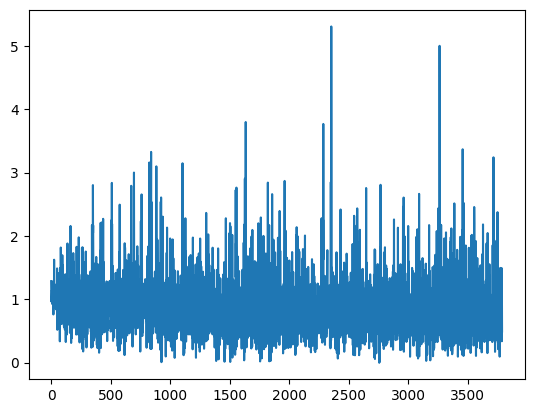

In [13]:
plt.plot(train_losses)

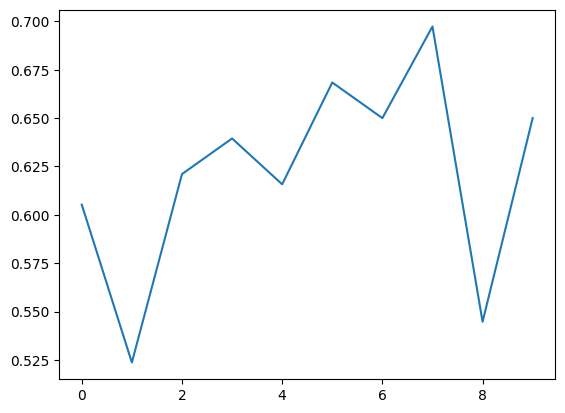

In [14]:
plt.plot(test_accuracy)

In [15]:
data_improv = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='improvised'
              )
all_labels_improv = sorted(list(set(datapoint[3] for datapoint in data_improv)))
print(all_labels_improv)
data_improv_x = []
data_improv_y = []
for d in data_improv:
    if d[3] in labels:
        data_improv_x.append(d)
        data_improv_y.append(label_to_index(d[3]))
improv_test_loader = torch.utils.data.DataLoader(
    data_improv_x,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [16]:
metrics_improv, confusion_matrix_improv = report_metrics(
    model, labels=labels, device=device, test_loader=improv_test_loader)
pprint(metrics_improv.compute())
confusion_matrix_improv.compute()

Correct: 1154/1996 (0.5782)
{'acc_detail': tensor([0.8927, 0.3012, 0.9293], device='cuda:0'),
 'acc_unweighted': tensor(0.7077, device='cuda:0'),
 'acc_weighted': tensor(0.5782, device='cuda:0'),
 'f1s': tensor(0.5807, device='cuda:0'),
 'f1s_detail': tensor([0.6247, 0.4479, 0.6694], device='cuda:0'),
 'precision_detail': tensor([0.4804, 0.8734, 0.5231], device='cuda:0'),
 'recall_detail': tensor([0.8927, 0.3012, 0.9293], device='cuda:0'),
 'rocauc': tensor([0.9388, 0.6771, 0.8173], device='cuda:0'),
 'uar': tensor(0.7077, device='cuda:0'),
 'wap': tensor(0.7098, device='cuda:0')}


tensor([[258,  19,  12],
        [265, 331, 503],
        [ 14,  29, 565]], device='cuda:0')

In [15]:
del model
gc.collect()

0